<a href="https://colab.research.google.com/github/tremblay17/Machine-Learning-Projects/blob/main/StockPrediction-v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Installs
#!pip install yfinance

In [ ]:
#@title Imports
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

import pandas as pd
from google.colab import widgets
import ipywidgets as widgets
from IPython.display import display, clear_output
from datetime import datetime

In [ ]:
#@title Functions

def create_dataset(dataset, step):
    x_train, y_train = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        x_train.append(a)
        y_train.append(dataset[i + step, 0])
    return np.array(x_train), np.array(y_train)

def plot1(PST, timeframe):
  if PST:
    timeframe.plot()
    plt.ylabel("Price")
    plt.title(f"Plain {ticker} {Timeframe} Plot")

def PlotPred(prediction3mo, ticker, Plot_Prediction, PS3, data):
  predictedPrice = round(float(*prediction3mo[len(prediction3mo)-1]),2)
  if Plot_Prediction and PS3:
    fig, ax = plt.subplots(figsize=(10,6))
    plt.plot(prediction3mo,)
    #ax.plot()
    #ax.set_title('Simple plot')
    #plt.subplots(figsize=(10,6))
    #fig, axs = plt.subplots(figsize=(10,6))
    #ax.plot(prediction3mo,)
    plt.ylabel("Price ($)")
    ax.set_title(f"{ticker}'s predicted price, 3 months shown")
    plt.axvline(len(prediction3mo)-31, ls = '--')
    plt.axhline(y=prediction3mo[len(prediction3mo)-1], color = 'blue', linestyle = ':', label = f'30 Day Price: {predictedPrice}')
    plt.legend()
  else:
    print(f"Predicted Price for {ticker} in one month's time: ${predictedPrice} ")

def PlotPred2(prediction1y, ticker, Plot_Prediction, PS1, data):
  predictedPrice = round(float(*prediction1y[len(prediction1y)-1]),2)
  if Plot_Prediction and PS1:
    fig, axs = plt.subplots(1, figsize=(10,6))
    plt.axvline(len(prediction1y)-31, ls = '--')
    plt.plot(prediction1y,)
    plt.ylabel("Price ($)")
    plt.title(f"{ticker}'s predicted price, 1 year shown")
    plt.axhline(y=prediction1y[len(prediction1y)-1], color = 'blue', linestyle = ':', label = f'30 Day Price: {predictedPrice}')
    plt.legend()
  else:
    print(f"Predicted Price for {ticker} in one month's time: ${predictedPrice}")

def dateSubtractor(pre, years):
  pre = list(pre)
  pre[4] = 0
  pre[7] = 0
  numerical = ''.join(str(a) for a in pre)
  numerical = int(numerical)
  sub = 5
  if years == '2y':
    sub = 2000000
  elif years == '5y':
    sub = 5000000
  else:
    sub = 10000000
  numerical = numerical - sub
  post = list(str(numerical))
  post[4] = '-'
  post[7] = '-'
  nruter = ''.join(post)
  return nruter

In [ ]:
#@title User Input { run: "auto", vertical-output: true, form-width: "50%", display-mode: "form" }
Desired_Ticker = 'F' #@param {type:"string"}
ticker = Desired_Ticker
ProgramType = 'Live' #@param ['Live', 'Historical']
if ProgramType == 'Live':
  print("   -------Live (Current) Prediction Selected.------- \n---Historical and Checker date entry is irrelevant.---")
print("\nLive predicts future values;\nHistorical prediction ends at specified date,\nstarting Training Period Years before.\nUseful for accuracy testing.")

Training_Period_Years = '5y' #@param ['5y', '2y', '10y']
print("\nTraining Period of 5 years is generally best\n")
print("Add 1 or 2 months to End_Date_For_Historical\n")
Start_Date_For_Historical = '2013-01-01' #@param {type:"date"}
StartDateH = Start_Date_For_Historical
End_Date_For_Historical = '2017-02-01' #@param {type:"date"}
EndDate = End_Date_For_Historical
#StartDate = dateSubtractor(EndDate, Training_Period_Years) #Use for Automated StartDate
End_Date_For_Checker = '2017-03-28' #@param {type:"date"}
Timeframe = 'Close' #@param ['Close', 'Open']
Epochs = 25 #@param {type:"slider", min:1, max:100, step:1}
print("20-40 Epochs tends to be quick\n")
epochAMT = Epochs
Batch = 64 #@param {type:"slider", min:1, max:128, step:1}
print("64 batch size is average")

   -------Live (Current) Prediction Selected.------- 
---Historical and Checker date entry is irrelevant.---

Live predicts future values;
Historical prediction ends at specified date,
starting Training Period Years before.
Useful for accuracy testing.

Training Period of 5 years is generally best

Add 1 or 2 months to End_Date_For_Historical

20-40 Epochs tends to be quick

64 batch size is average


In [ ]:
#@title User Options { run: "auto", vertical-output: true, form-width: "50%", display-mode: "form" }
Plot_Selected_Timeframe_Plain = True #@param {type:"boolean"}
PST = Plot_Selected_Timeframe_Plain
Plot_Pre_Prediction = False #@param {type:"boolean"}
PPP = Plot_Pre_Prediction
Plot_Unscaled_Prediction = False #@param {type:"boolean"}
PUP = Plot_Unscaled_Prediction
Plot_Final_Prediction = True # AT param {type:"boolean"}
Plot_Prediction = Plot_Final_Prediction

PS1 = False; PS3 = False
Final_Prediction_Scale_1Year = True #@param {type:"boolean"}
Final_Prediction_Scale_3Months = True #@param {type:"boolean"}
if Final_Prediction_Scale_1Year:
  PS1 = True
if Final_Prediction_Scale_3Months:
  PS3 = True

In [ ]:
#@title Data Processing
if ProgramType == 'Live':
  data = yf.download(tickers = ticker, period=Training_Period_Years, interval = '1d', progress = False)
elif ProgramType == 'Historical':
  data = yf.download(tickers = ticker, start = StartDateH, end = EndDate, interval = '1d', progress = False)
  Checker = yf.download(tickers = ticker, start = StartDateH, end = End_Date_For_Checker, interval = '1d', progress = False)
  diffr = len(Checker) - len(data)
  print("Historical Selected\n")
timeframe = data[[Timeframe]]
ds = timeframe.values

normalization = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalization.fit_transform(np.array(ds).reshape(-1,1))

train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

time_step = 100
X_train, y_train = create_dataset(ds_train, time_step)
X_test, y_test = create_dataset(ds_test, time_step)

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


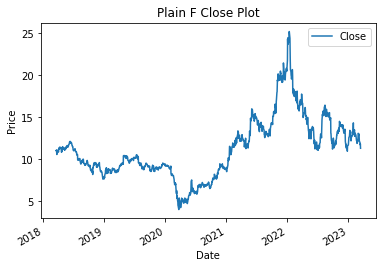

In [ ]:
#@title Plain Plot
plot1(PST, timeframe) # plots plain open/close graph

In [ ]:
#@title Training
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))

model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
#@title Fitting
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochAMT,batch_size=Batch)

Epoch 1/25
13/13 [==============================] - 21s 461ms/step - loss: 0.0296 - val_loss: 0.0140
Epoch 2/25
13/13 [==============================] - 3s 222ms/step - loss: 0.0056 - val_loss: 0.0036
Epoch 3/25
13/13 [==============================] - 5s 370ms/step - loss: 0.0030 - val_loss: 0.0073
Epoch 4/25
13/13 [==============================] - 3s 249ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 5/25
13/13 [==============================] - 5s 372ms/step - loss: 0.0010 - val_loss: 0.0042
Epoch 6/25
13/13 [==============================] - 3s 226ms/step - loss: 0.0010 - val_loss: 0.0034
Epoch 7/25
13/13 [==============================] - 7s 541ms/step - loss: 9.2665e-04 - val_loss: 0.0031
Epoch 8/25
13/13 [==============================] - 3s 228ms/step - loss: 9.0923e-04 - val_loss: 0.0029
Epoch 9/25
13/13 [==============================] - 3s 221ms/step - loss: 8.6725e-04 - val_loss: 0.0027
Epoch 10/25
13/13 [==============================] - 4s 295ms/step - loss: 8.4908e-04 -

In [ ]:
#@title Predictions
training_prediction = model.predict(X_train)
testing_prediction = model.predict(X_test)
training_prediction = normalization.inverse_transform(training_prediction)
testing_prediction = normalization.inverse_transform(testing_prediction)

test = np.vstack((training_prediction,testing_prediction))

minhun = len(ds_test) - 100
fut_inp = ds_test[minhun:]
fut_inp = fut_inp.reshape(1,-1)
tmp_inp = list(fut_inp)
tmp_inp = tmp_inp[0].tolist()

9/9 [==============================] - 1s 69ms/step


In [ ]:
#@title Layering
lst_output=[]
n_steps=100
i=0
while(i<30):
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1

In [ ]:
#@title Plotting Pre-Prediction
plot_new = np.arange(1,101)
plot_pred = np.arange(101,131)
minhun2 = len(ds_scaled) - 100
if PPP:
  plt.plot(plot_new, normalization.inverse_transform(ds_scaled[minhun2:]))
  plt.plot(plot_pred, normalization.inverse_transform(lst_output))


In [ ]:
#@title Plotting Prediction (unscaled)
ds_new = ds_scaled.tolist()
ds_new.extend(lst_output)
extend_length = len(ds_new) - 130
if PUP:
  plt.plot(ds_new[extend_length:])

In [ ]:
#@title Prediction Scaling
prev3mo = len(ds_new) - 92
if ProgramType == 'Live':
  prev1y = len(ds_new) - 365
elif ProgramType == 'Historical':
   prev1y = len(ds_new) - 365 + diffr
prediction1y = normalization.inverse_transform(ds_new[prev1y:]).tolist()
prediction3mo = normalization.inverse_transform(ds_new[prev3mo:]).tolist()

	Current Day Shown via Horizontal Dashed Line



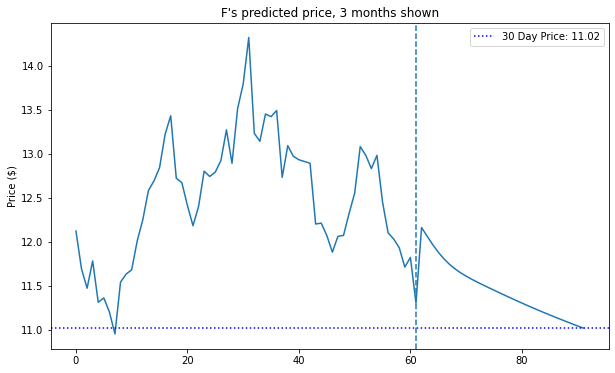

In [ ]:
#@title 3 Month Scale
print("\tCurrent Day Shown via Horizontal Dashed Line\n")
if ProgramType != 'Live':
  print(f"\t-----Current Day: {EndDate} -----")
PlotPred(prediction3mo, ticker, Plot_Prediction, PS3, data)


In [ ]:
#@title 3 Month Checker Plot
if ProgramType != 'Live':
  #plt.plot(Checker[Timeframe].values[-len(prediction3mo):])
  fig, axs = plt.subplots(1, figsize=(10,6))
  delta2 = len(Checker) - len(prediction3mo) + 5 #+ 1/5 diffr
  plot3mo = Checker[Timeframe].values[delta2:]
  plt.plot(plot3mo)
  plt.axvline(len(plot3mo)-31, ls = '--')

	Current Day Shown via Horizontal Dashed Line



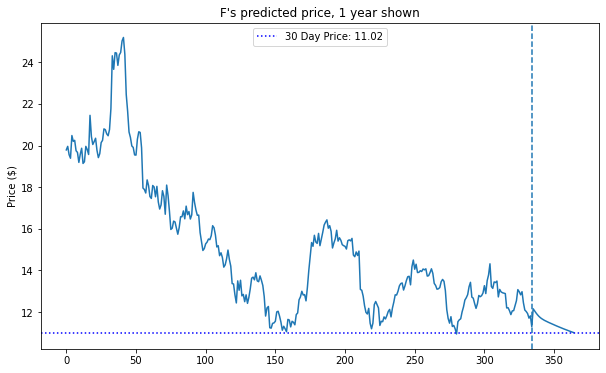

In [ ]:
#@title 1 Year Scale
print("\tCurrent Day Shown via Horizontal Dashed Line\n")
if ProgramType != 'Live':
  print(f"\t-----Current Day: {EndDate} -----")
PlotPred2(prediction1y, ticker, Plot_Prediction, PS1, data)


In [ ]:
#@title 1 Year Checker Plot
if ProgramType != 'Live':
  fig, axs = plt.subplots(1, figsize=(10,6))
  delta = len(data) - len(prediction1y) + diffr
  plot1y = Checker[Timeframe].values[delta:]
  plt.plot(plot1y)
  plt.axvline(len(plot1y)-31, ls = '--')